In [1]:
%matplotlib inline
import yaml
from sklearn import linear_model
from sklearn.model_selection import LeaveOneGroupOut, cross_val_score
import os
import importlib
import matplotlib.pyplot as plt
import sys
import numpy as np
import seaborn as sns
import pandas as pd

nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

In [2]:
from machine_learning import pipeline, features_sensor, labels, model

In [3]:
importlib.reload(labels)

<module 'machine_learning.labels' from 'C:\\Users\\junos\\Documents\\FWO-ARRS\\Analysis\\straw2analysis\\machine_learning\\labels.py'>

In [4]:
with open("./config/prox_comm_PANAS_features.yaml", "r") as file:
    sensor_features_params = yaml.safe_load(file)
sensor_features = features_sensor.SensorFeatures(**sensor_features_params)
#sensor_features.set_sensor_data()
sensor_features.calculate_features(cached=True)

SensorFeatures initialized.
Calculating features ...
Read proximity features from the file.
Read communication features from the file.


In [5]:
all_features = sensor_features.get_features("all","all")

In [6]:
with open("./config/prox_comm_PANAS_labels.yaml", "r") as file:
    labels_params = yaml.safe_load(file)
labels_current = labels.Labels(**labels_params)
#labels_current.set_labels()
labels_current.aggregate_labels(cached=True)

Labels initialized.
Aggregating labels ...
Read labels from the file.


In [7]:
model_validation = model.ModelValidation(
    sensor_features.get_features("all", "all"),
    labels_current.get_aggregated_labels(),
    group_variable="participant_id",
    cv_name="loso",
)
model_validation.model = linear_model.LinearRegression()
model_validation.set_cv_method()

ModelValidation initialized.
Validation method set.


In [8]:
model_loso_r2 = model_validation.cross_validate()

Running cross validation ...


In [9]:
print(model_loso_r2)
print(np.mean(model_loso_r2))

[-8.50176280e-02 -3.66239404e-02 -5.77416259e-01 -9.06942628e-01
 -3.13084482e+00 -5.25290051e-02 -2.32414699e+00 -7.65972845e+00
 -3.65181380e+00 -9.62417876e+00 -7.44270369e-02  6.78427260e-02
 -5.69919784e-01 -9.03242379e-01 -1.21151912e-01 -5.13453030e+00
 -1.60384696e+00 -3.19062741e+00 -6.63847516e-01 -9.90156817e-02
 -7.72057926e-01 -4.90843105e+01  3.69446095e-01 -2.08765985e+00
 -1.99641377e+00 -1.29034837e+03 -3.21364491e+00 -5.77331614e-01
  0.00000000e+00 -6.84298747e-03 -1.63138097e+01 -1.66204067e+00
 -2.27751119e-01 -1.33661361e+00 -9.81485624e-01 -8.49005069e+00
 -1.54261232e+01 -1.07208976e+01 -5.94109632e-01 -1.46186838e-01
 -3.35992820e-01 -1.56058931e-01 -4.30691060e+00 -4.02218511e+00
 -1.76476411e+01 -4.87642855e-02 -5.30649694e+00 -2.17399142e-01
 -4.13520657e-01 -3.86148143e+00 -8.01412328e-01 -8.23760834e+00
 -2.06664107e+00 -1.18230651e+00 -2.06091099e-02 -9.97601126e-02]
-26.655054402780422


In [10]:
model_loso_r2[model_loso_r2 > 0]

array([0.06784273, 0.36944609])

In [11]:
logo = LeaveOneGroupOut()

In [12]:
try_X = model_validation.X.reset_index().drop(["participant_id","date_lj"], axis=1)
try_y = model_validation.y.reset_index().drop(["participant_id","date_lj"], axis=1)

In [13]:
model_loso_mean_absolute_error = -1 * cross_val_score(
estimator=model_validation.model,
X=try_X,
y=try_y,
groups=model_validation.groups,
cv=logo.split(X=try_X, y=try_y, groups=model_validation.groups), 
scoring='neg_mean_absolute_error'
)

In [14]:
model_loso_mean_absolute_error

array([ 0.43618444,  0.39780929,  0.56970789,  0.38847095,  0.78244762,
        0.29847855,  0.4348883 ,  1.80633684,  0.29097794,  0.53106755,
        0.32757327,  0.37845186,  0.30228743,  0.34129752,  0.2555845 ,
        1.27981007,  0.40270591,  0.35411635,  0.2568122 ,  0.5820276 ,
        0.33293713,  0.47789249,  0.19690204,  0.68629304,  0.67457704,
       13.0369228 ,  0.41234072,  0.31384332,  0.45126702,  0.34806906,
        0.52854722,  0.28707449,  0.28282637,  0.49286602,  0.26406791,
        0.39567315,  0.33661383,  1.23764371,  0.43788937,  0.32592072,
        0.47443271,  0.55999948,  0.50408039,  0.40523803,  0.50241167,
        0.30617356,  0.31461521,  0.28494495,  0.32278505,  0.29084659,
        0.47211231,  0.33807521,  0.34608592,  0.40624902,  0.22882316,
        0.45563856])

In [15]:
np.median(model_loso_mean_absolute_error)

0.39674122009711504

In [16]:
model_validation.model.fit(try_X, try_y)

LinearRegression()

In [17]:
Y_predicted = model_validation.model.predict(try_X)

In [18]:
try_y.rename(columns={"NA": "NA_true"}, inplace=True)
try_y["NA_predicted"] = Y_predicted
NA_long = pd.wide_to_long(
    try_y.reset_index(),
    i="index",
    j="value",
    stubnames="NA",
    sep="_",
    suffix=".+",
)

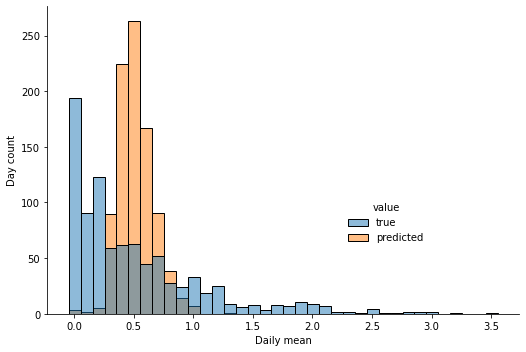

In [19]:
g1 = sns.displot(NA_long, x="NA", hue="value", binwidth=0.1, height=5, aspect=1.5)
sns.move_legend(g1, "upper left", bbox_to_anchor=(.55, .45))
g1.set_axis_labels("Daily mean", "Day count")

display(g1)
g1.savefig("prox_comm_PANAS_predictions.pdf")

In [20]:
from sklearn.metrics import mean_absolute_error

In [21]:
mean_absolute_error(try_y["NA_true"], try_y["NA_predicted"])

0.42725018860641295

In [22]:
model_loso_mean_absolute_error

array([ 0.43618444,  0.39780929,  0.56970789,  0.38847095,  0.78244762,
        0.29847855,  0.4348883 ,  1.80633684,  0.29097794,  0.53106755,
        0.32757327,  0.37845186,  0.30228743,  0.34129752,  0.2555845 ,
        1.27981007,  0.40270591,  0.35411635,  0.2568122 ,  0.5820276 ,
        0.33293713,  0.47789249,  0.19690204,  0.68629304,  0.67457704,
       13.0369228 ,  0.41234072,  0.31384332,  0.45126702,  0.34806906,
        0.52854722,  0.28707449,  0.28282637,  0.49286602,  0.26406791,
        0.39567315,  0.33661383,  1.23764371,  0.43788937,  0.32592072,
        0.47443271,  0.55999948,  0.50408039,  0.40523803,  0.50241167,
        0.30617356,  0.31461521,  0.28494495,  0.32278505,  0.29084659,
        0.47211231,  0.33807521,  0.34608592,  0.40624902,  0.22882316,
        0.45563856])